## Amplitude analysis

In [5]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [6]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if zero_padding:
        ind = np.arange(n-1)
        a = np.insert(a, ind, np.zeros(n-1))
        a = np.roll(a, -int((n-1)/2))
    if const_padding:
        if n%2 != 1:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n-1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n/2)))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
        else:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n+1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n-1)/2))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [7]:
def min_max_in_window(a, window, return_index = False):
    xmin, xmax = 0,0
    arg_min, arg_max = 0,0
    for i in np.arange(len(a)-window+1):
        interval = a[i:i+window]
        tmin = interval.min() #temporary min
        tmax = interval.max() #temporary max
        t_argmin = np.argmin(interval)+i
        t_argmax = np.argmax(interval)+i
        if (tmax-tmin > xmax-xmin): 
            xmin, xmax = tmin, tmax
            arg_min, arg_max = t_argmin, t_argmax
    if return_index:
        return xmax-xmin, arg_min, arg_max
    else:
        return xmax-xmin

In [8]:
dt = 0.1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 20*u.Msun}
         }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.006*u.s, tmax=0.338*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = True)
sim.run()

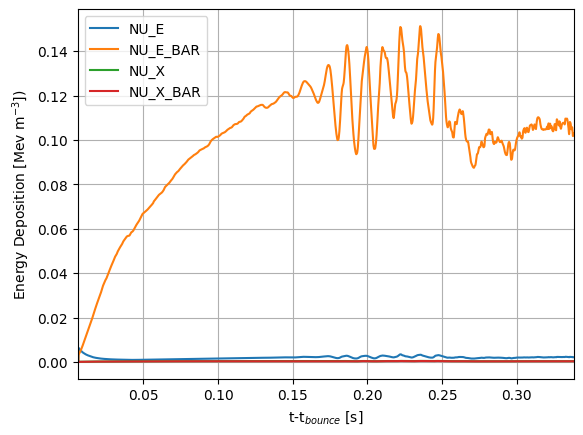

In [9]:
for flavor in sim.flavors:
    plt.plot(sim.time, sim.E_per_V[flavor], label=flavor.name)
plt.legend()
ax = plt.gca()
ax.set(xlabel=r't-t$_{bounce}$ [s]', ylabel='Energy Deposition [Mev m$^{-3}$])', xlim=(0.006, 0.338))
ax.grid()

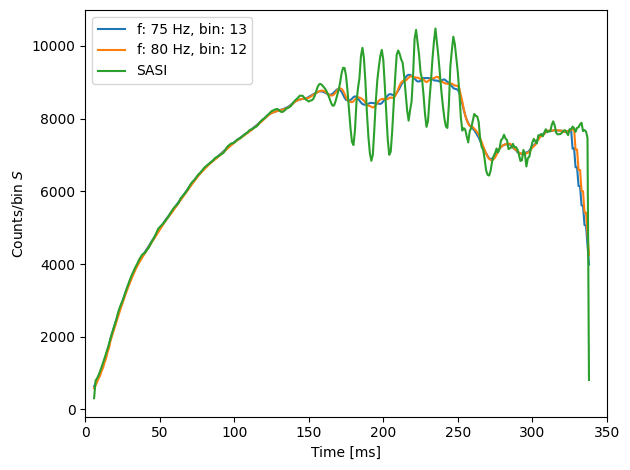

In [12]:
# Binning of the moving average filter defined by the Nyquist frequency of the SASI modulation
# If the sampling was to be finer the binning could be done finer, however this comes at the expense of lower
# statistics. Therefore we keep the sampling rate at 1 ms.

dt = 1*u.ms
f_range = np.arange(75,85,5)*u.Hz

for f in f_range:
    f_lb_sasi =  f
    duration = sim.time[-1]-sim.time[0]
    samples = (duration/dt.to(u.s)).value
    binning = int((1/f_lb_sasi*samples/duration).value) #binning needed to filter out sinals with f>f_lb_sasi

    #detector_signal s0 is not drawn from distribution
    t, s0_i3 = sim.detector_signal(dt=dt, subdetector='i3')
    t, s0_dc = sim.detector_signal(dt=dt, subdetector='dc')
    t, s0_md = sim.detector_signal(dt=dt, subdetector='md')

    s0_ic86 = s0_i3 + s0_dc
    s0_gen2 = s0_i3 + s0_dc + s0_md
    t = t.to(u.ms)

    #averaged signal sa binning size defined by the Nyquist frequency of the SASI modulation and constant padding
    sa_ic86 = moving_average(s0_ic86, n=binning, const_padding=True)
    sa_gen2 = moving_average(s0_gen2, n=binning, const_padding=True)

    plt.plot(t,sa_gen2, label = 'f: {:.0f}, bin: {:d}'.format(f, binning))
plt.plot(t,s0_gen2,label='SASI')
plt.xlabel('Time [ms]')
plt.ylabel(r'Counts/bin $S$')
plt.legend()
plt.xlim(0,350)
plt.tight_layout()

In [13]:
sasi_wind = [140, 300] * u.ms
ana_wind = [160, 275] * u.ms

In [29]:
# Binning of the moving average filter defined by the Nyquist frequency of the SASI modulation
# If the sampling was to be finer the binning could be done finer, however this comes at the expense of lower
# statistics. Therefore we keep the sampling rate at 1 ms.

dt = 1*u.ms

f_lb_sasi =  80*u.Hz
duration = sim.time[-1]-sim.time[0]
samples = (duration/dt.to(u.s)).value
binning = int((1/f_lb_sasi*samples/duration).value) #binning needed to filter out sinals with f>f_lb_sasi

#detector_signal s0 is not drawn from distribution
t, s0_i3 = sim.detector_signal(dt=dt, subdetector='i3')
t, s0_dc = sim.detector_signal(dt=dt, subdetector='dc')
t, s0_md = sim.detector_signal(dt=dt, subdetector='md')

s0_ic86 = s0_i3 + s0_dc
s0_gen2 = s0_i3 + s0_dc + s0_md
t = t.to(u.ms)

#averaged signal sa binning size defined by the Nyquist frequency of the SASI modulation and constant padding
sa_ic86 = moving_average(s0_ic86, n=binning, const_padding=True)
sa_gen2 = moving_average(s0_gen2, n=binning, const_padding=True)

#average background given by the mean of the sensor distribution and scaled to the full detector
ba_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
ba_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)


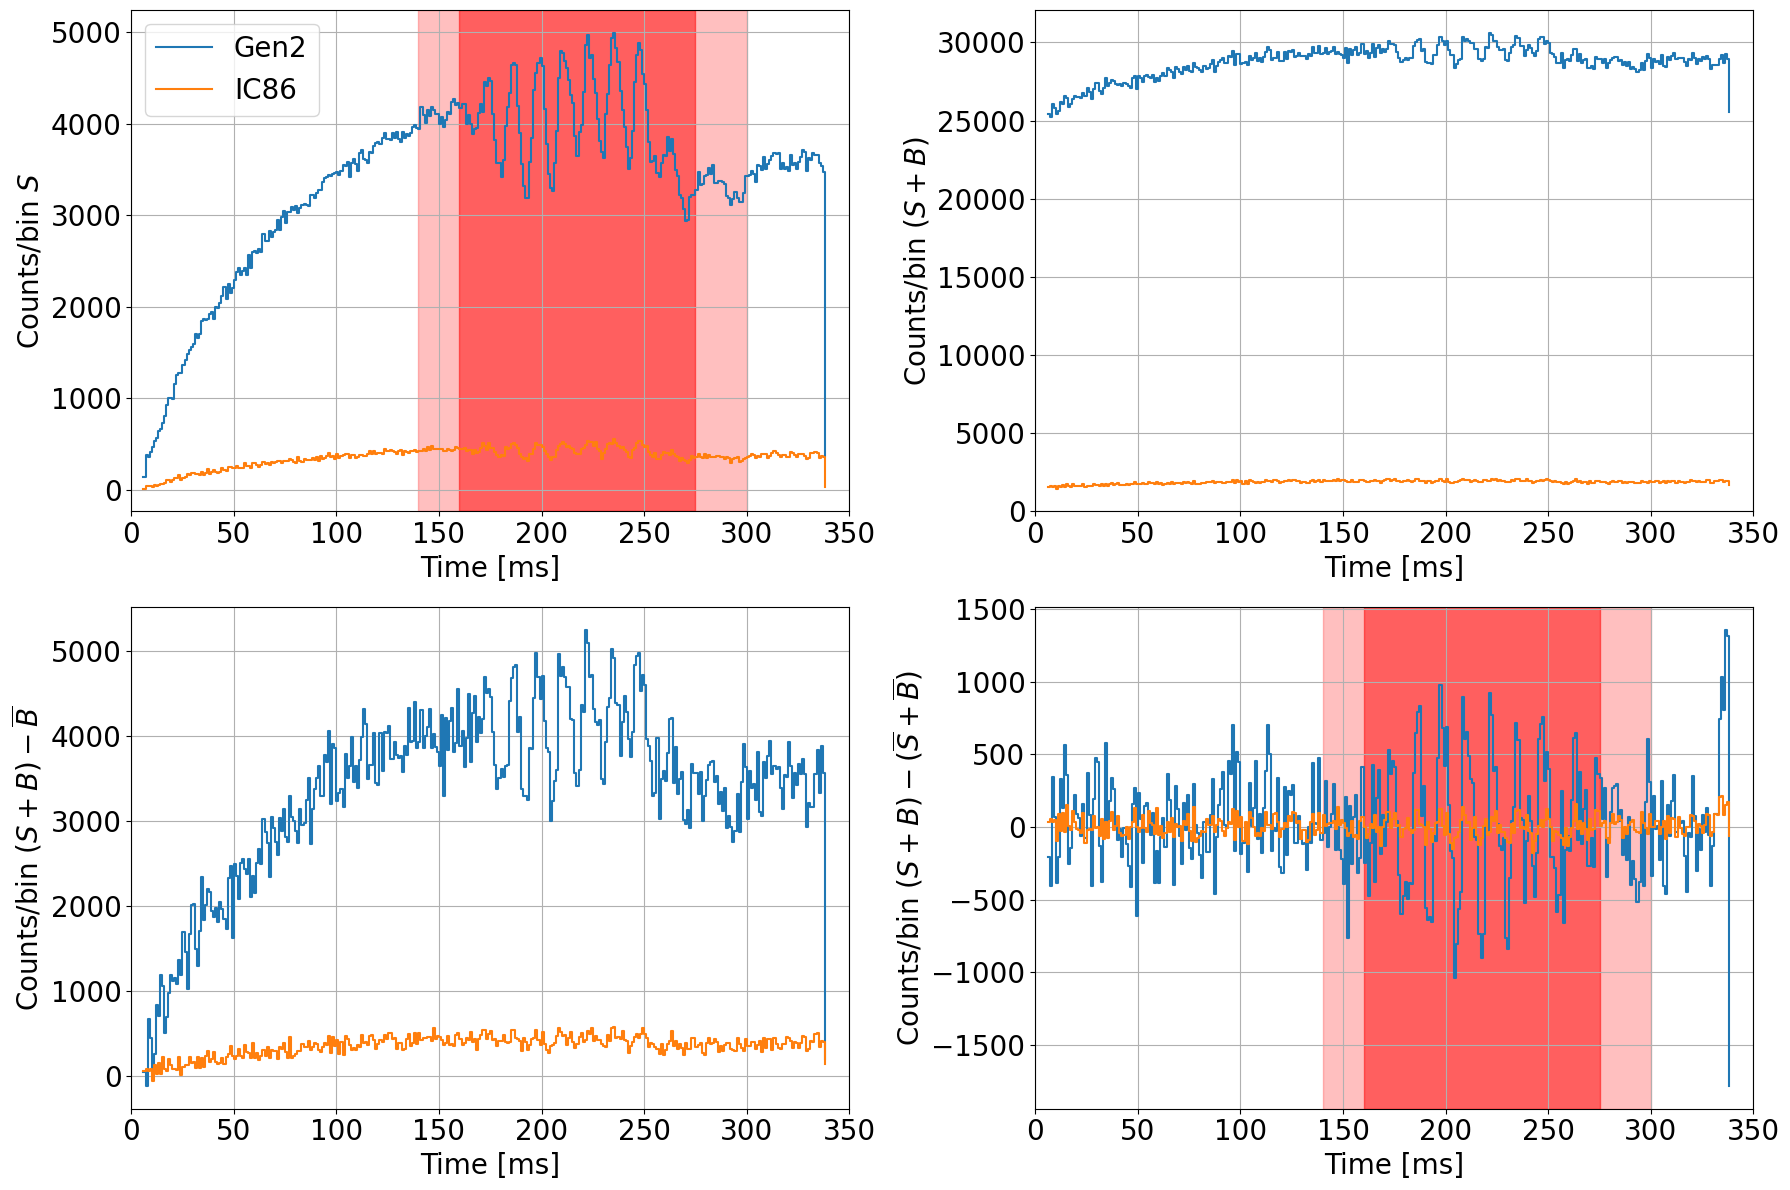

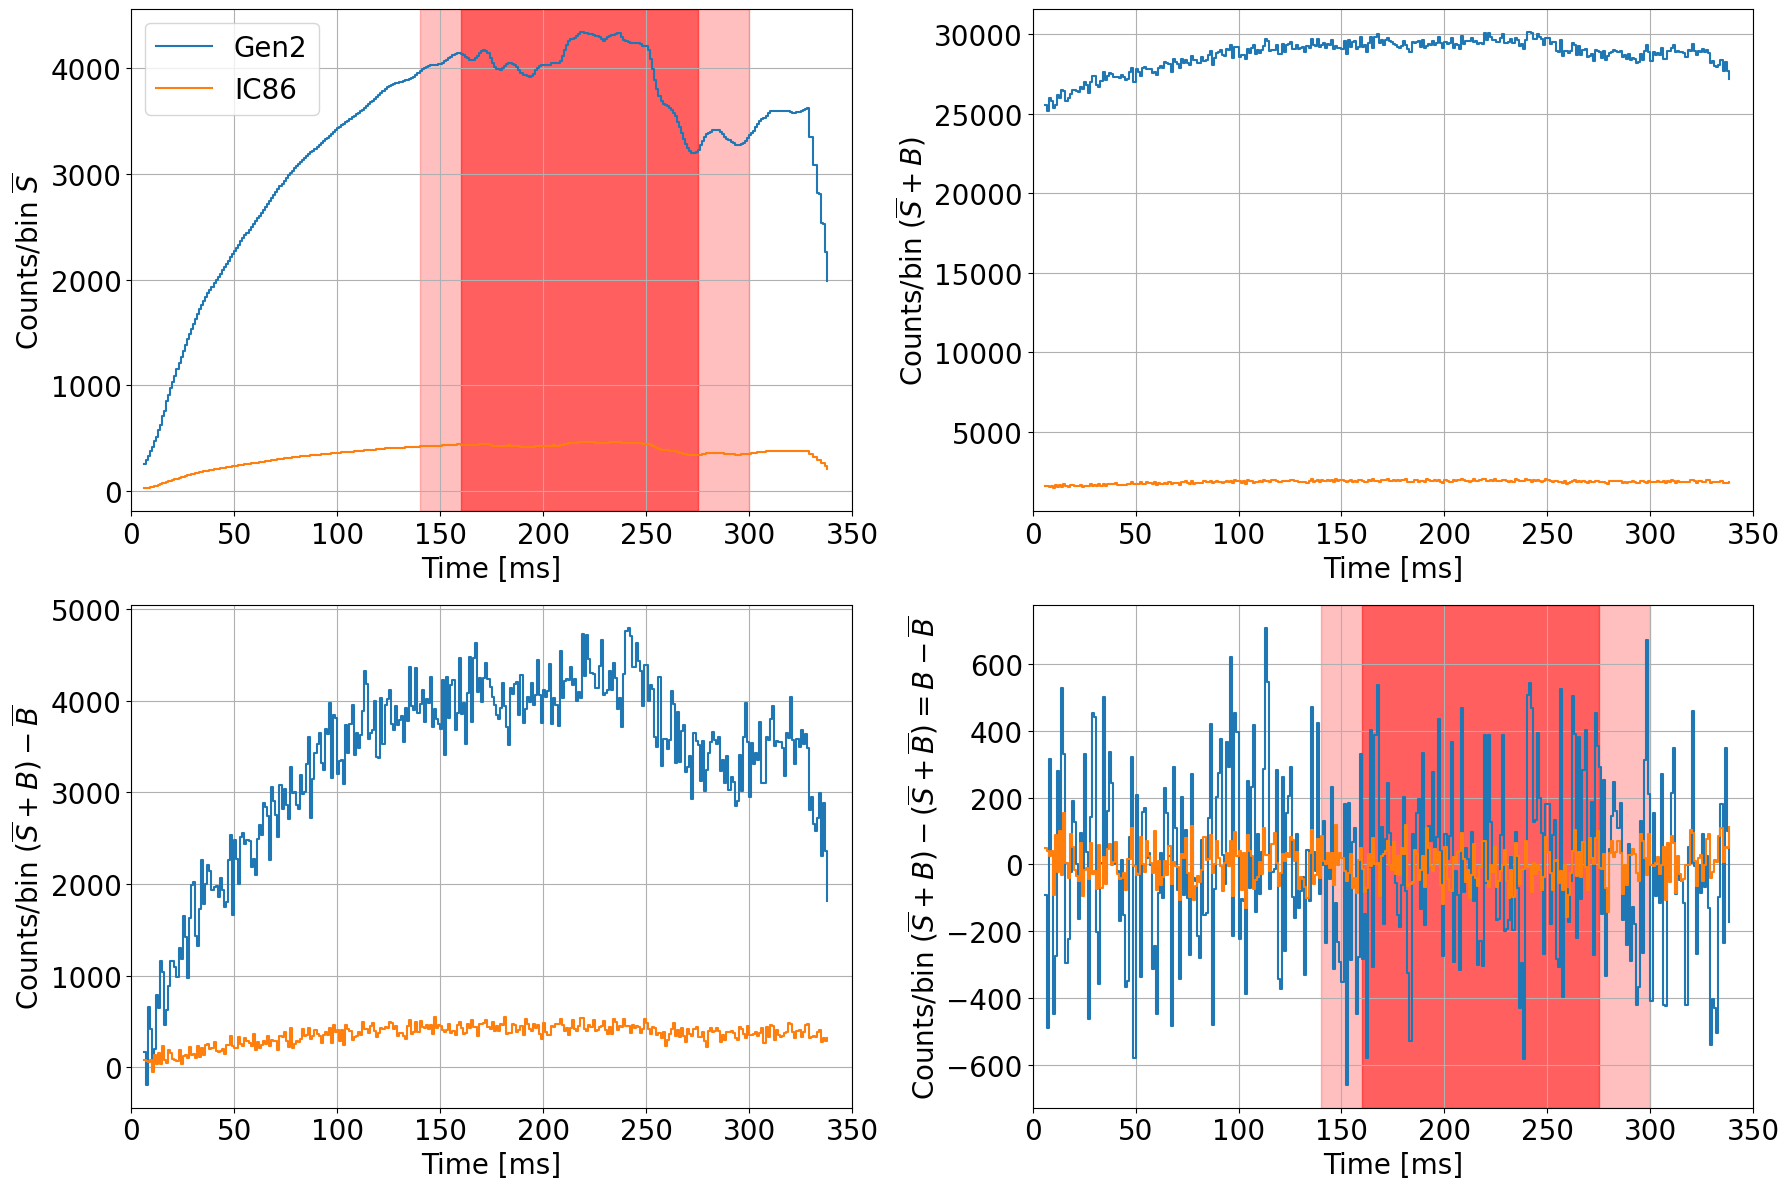

In [32]:
sim.scale_result(distance=15*u.kpc)

# time and signal for each detector component [counts/bin]
t, s_i3 = sim.detector_hits(dt=dt, subdetector='i3')
t, s_dc = sim.detector_hits(dt=dt, subdetector='dc')
t, s_md = sim.detector_hits(dt=dt, subdetector='md')
#t, s_ws = sim.detector_hits(dt=dt, subdetector='ws')
t = t.to(u.ms)

# random background realization
b_i3 = sim.detector.i3_bg(dt=dt, size=len(s_i3))
b_dc = sim.detector.dc_bg(dt=dt, size=len(s_dc))
b_md = sim.detector.md_bg(dt=dt, size=len(s_md))
#b_ws = sim.detector.ws_bg(dt=dt, size=len(s_ws))

### SIGNAL TRIALS ###
s_ic86 = s_i3 + s_dc
s_gen2 = s_i3 + s_dc + s_md
b_ic86 = b_i3 + b_dc
b_gen2 = b_i3 + b_dc + b_md

# combined signal S: signal + background
S_ic86 = s_ic86 + b_ic86
S_gen2 = s_gen2 + b_gen2

# background subtraction Sb: signal + background - average background
Sb_ic86 = S_ic86 - ba_ic86
Sb_gen2 = S_gen2 - ba_gen2

# deviation Sd: signal + background - average background - average signal
Sd_ic86 = Sb_ic86 - sa_ic86
Sd_gen2 = Sb_gen2 - sa_gen2

# percentage deviation Sp: (signal + background - average background - average signal)/average signal
Sp_ic86 = Sd_ic86/sa_ic86
Sp_gen2 = Sd_gen2/sa_gen2

### BACKGROUND TRIALS ###

# combined signal S: average signal + background
B_ic86 = sa_ic86 + b_ic86
B_gen2 = sa_gen2 + b_gen2

# background subtraction Sb: average signal + background - average background
Bb_ic86 = B_ic86 - ba_ic86
Bb_gen2 = B_gen2 - ba_gen2

# deviation Sd: average signal + background - average background - average signal = background - average background
Bd_ic86 = b_ic86 - ba_ic86
Bd_gen2 = b_gen2 - ba_gen2

# percentage deviation Sp: (background - average background)/average signal
Bp_ic86 = Bd_ic86/sa_ic86
Bp_gen2 = Bd_gen2/sa_gen2


# Plot all stages of the signal processing chain for the signal and background trials individually
# Signal trials
fig, ax = plt.subplots(2,2, figsize=(18,12))
ax = ax.ravel()
ax[0].step(t, s_gen2, where='post', label='Gen2')
ax[0].step(t, s_ic86, where='post', label='IC86')
ax[0].set_ylabel(r"Counts/bin $S$", fontsize = 20)

ax[1].step(t, S_gen2, where='post')
ax[1].step(t, S_ic86, where='post')
ax[1].set_ylabel(r"Counts/bin $(S+B)$", fontsize = 20)

ax[2].step(t, Sb_gen2, where='post')
ax[2].step(t, Sb_ic86, where='post')
ax[2].set_ylabel(r"Counts/bin $(S+B)-\overline{B}$", fontsize = 20)

ax[3].step(t, Sd_gen2, where='post')
ax[3].step(t, Sd_ic86, where='post')
ax[3].set_ylabel(r"Counts/bin $(S+B)-(\overline{S}+\overline{B})$", fontsize = 20)
for i in range(4): #labels, limits, bands etc.
    ax[i].set_xlabel("Time [ms]", fontsize = 20)
    ax[i].set_xlim((0,350))
    ax[i].grid()
    ax[i].tick_params(labelsize = 20)
    if i == 0 or i == 3:
        ax[i].axvspan(sasi_wind[0].value,sasi_wind[1].value,color = 'red', alpha = 0.25)
        ax[i].axvspan(ana_wind[0].value,ana_wind[1].value,color = 'red', alpha = 0.5)
ax[0].legend(fontsize = 20)
plt.tight_layout()
plt.show()


# Background trials
fig, ax = plt.subplots(2,2, figsize=(18,12))
ax = ax.ravel()
ax[0].step(t, sa_gen2, where='post', label='Gen2')
ax[0].step(t, sa_ic86, where='post', label='IC86')
ax[0].set_ylabel(r"Counts/bin $\overline{S}$", fontsize = 20)

ax[1].step(t, B_gen2, where='post')
ax[1].step(t, B_ic86, where='post')
ax[1].set_ylabel(r"Counts/bin $(\overline{S}+B)$", fontsize = 20)

ax[2].step(t, Bb_gen2, where='post')
ax[2].step(t, Bb_ic86, where='post')
ax[2].set_ylabel(r"Counts/bin $(\overline{S}+B)-\overline{B}$", fontsize = 20)

ax[3].step(t, Bd_gen2, where='post')
ax[3].step(t, Bd_ic86, where='post')
ax[3].set_ylabel(r"Counts/bin $(\overline{S}+B)-(\overline{S}+\overline{B})=B-\overline{B}$", fontsize = 20)
for i in range(4): #labels, limits, bands etc.
    ax[i].set_xlabel("Time [ms]", fontsize = 20)
    ax[i].set_xlim((0,350))
    ax[i].grid()
    ax[i].tick_params(labelsize = 20)
    if i == 0 or i == 3:
        ax[i].axvspan(sasi_wind[0].value,sasi_wind[1].value,color = 'red', alpha = 0.25)
        ax[i].axvspan(ana_wind[0].value,ana_wind[1].value,color = 'red', alpha = 0.5)
ax[0].legend(fontsize = 20)
plt.tight_layout()
plt

13


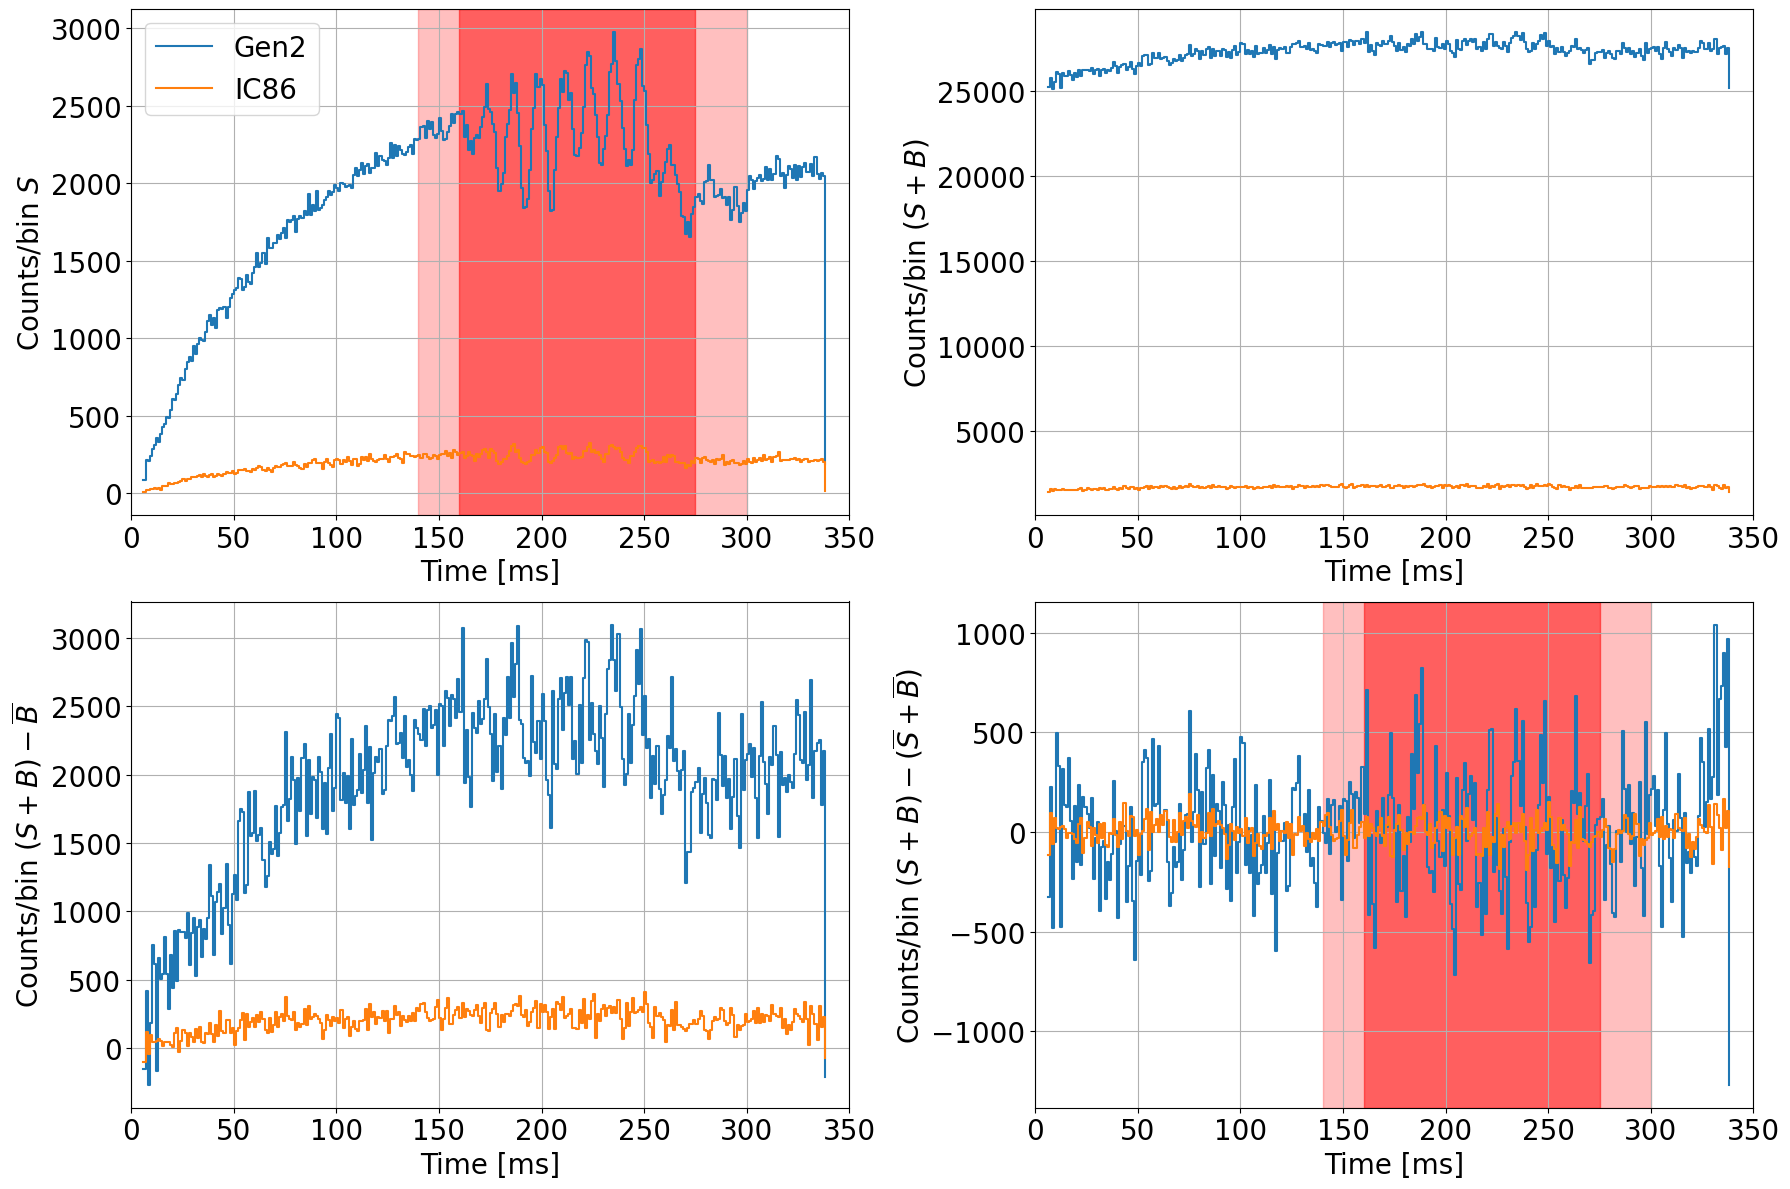

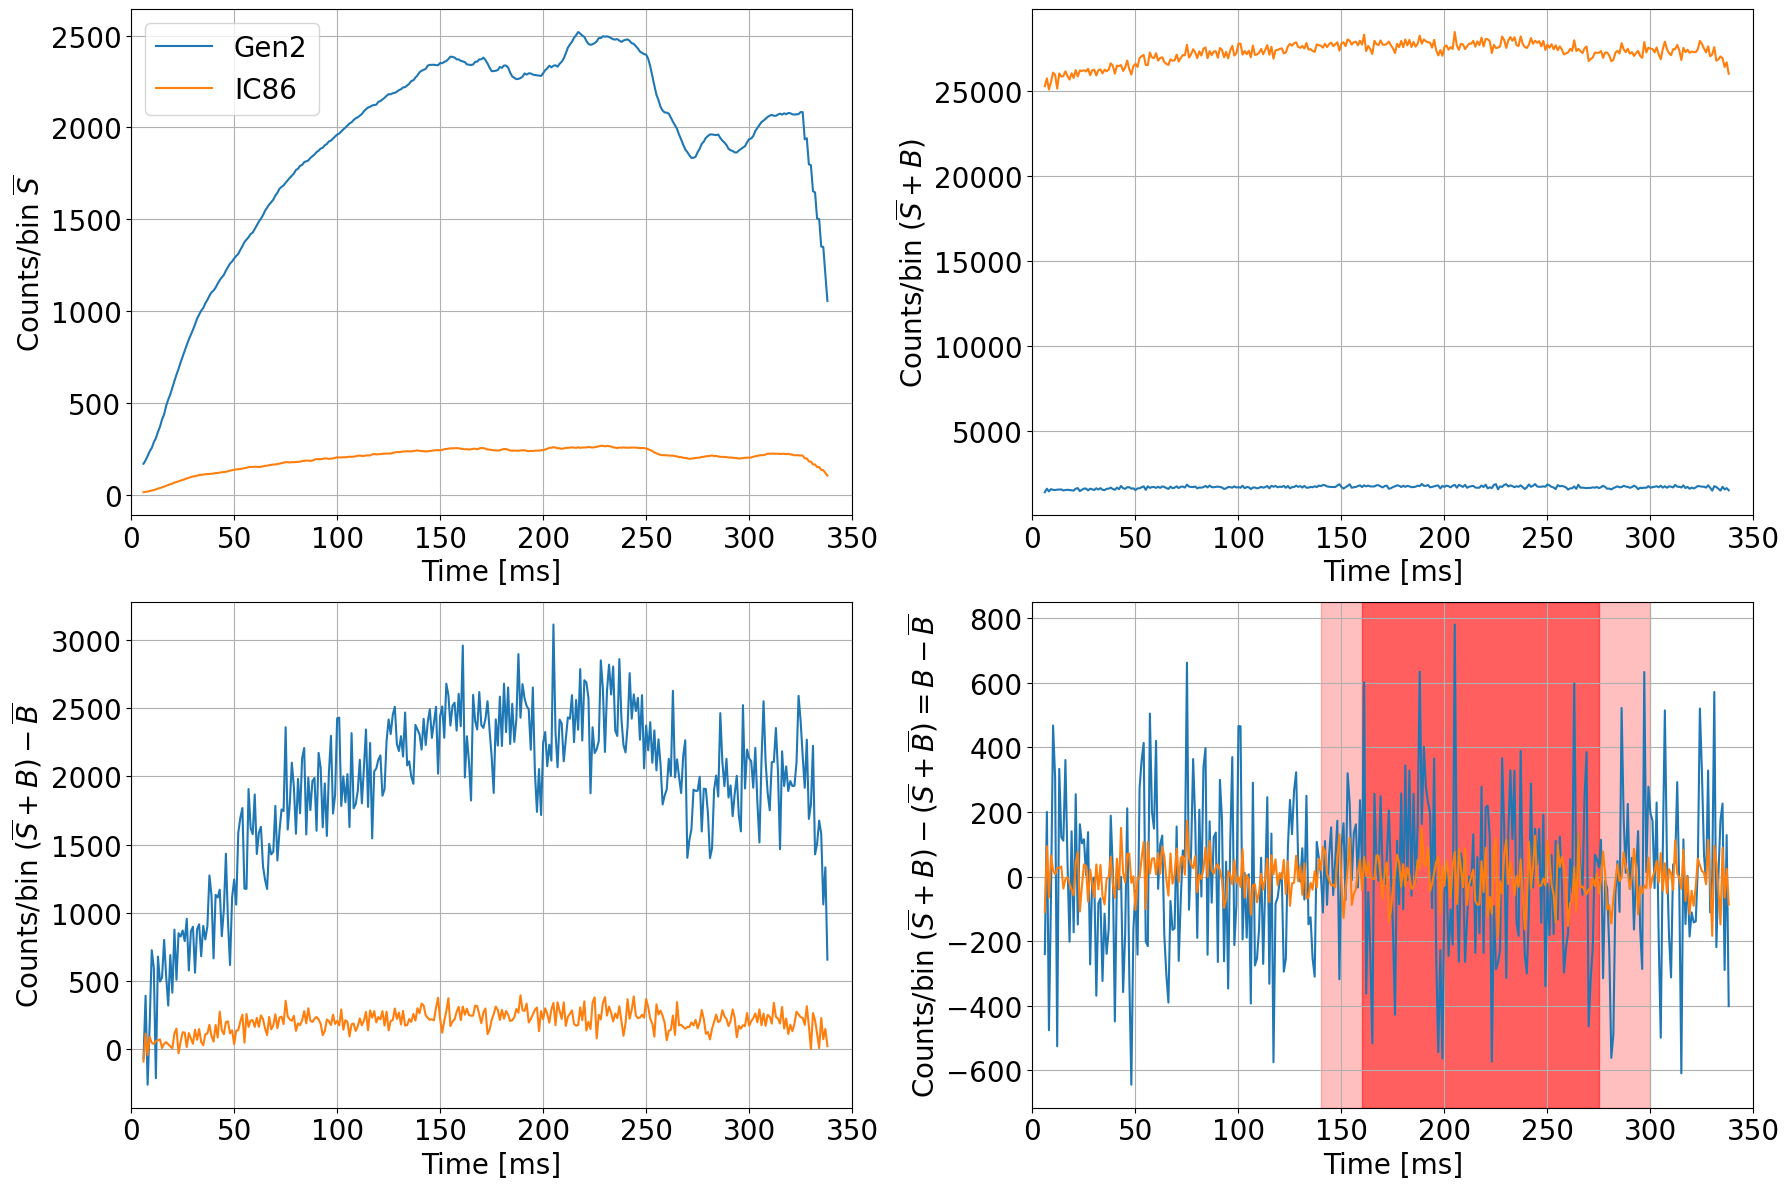

In [114]:
sasi_wind = [140, 300] * u.ms
ana_wind = [160, 275] * u.ms

sim.scale_result(distance=20*u.kpc)




# time and signal for each detector component [counts/bin]
t, i3_sig = sim.detector_hits(dt=dt, subdetector='i3')
t, dc_sig = sim.detector_hits(dt=dt, subdetector='dc')
t, md_sig = sim.detector_hits(dt=dt, subdetector='md')
t, comb_sig = sim.detector_hits(dt=dt)


# random background realization
i3_bkg = sim.detector.i3_bg(dt=dt, size=len(i3_sig))
dc_bkg = sim.detector.dc_bg(dt=dt, size=len(dc_sig))
md_bkg = sim.detector.md_bg(dt=dt, size=len(md_sig))
comb_bkg = i3_bkg + dc_bkg + md_bkg


sig_ic86 = i3_sig + dc_sig
sig_gen2 = comb_sig


bkg_ic86 = i3_bkg + dc_bkg
bkg_gen2 = comb_bkg

# combined signal + background counts
ic86 = sig_ic86 + bkg_ic86
gen2 = sig_gen2 + bkg_gen2



# moving average sig + bkg
avg_ic86 = sig_avg_ic86 + bkg_ic86
avg_gen2 = sig_avg_gen2 + bkg_gen2

# average background rate given by the mean of the sensor distribution and scaled to the full detector
bkg_avg_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
bkg_avg_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)

# deviation between the moving average and the combined (sig+bkg) hit rate
dev_ic86 = ic86-sig_avg_ic86-bkg_avg_ic86
dev_gen2 = gen2-sig_avg_gen2-bkg_avg_gen2

# SASI signal
fig, ax = plt.subplots(2,2, figsize=(18,12))
ax = ax.ravel()
ax[0].step(t, sig_gen2, where='post', label='Gen2')
ax[0].step(t, sig_ic86, where='post', label='IC86')
#ax[0].plot(t, sig_avg_gen2, ls = '-', color = 'red')
ax[0].axvspan(sasi_wind[0].value,sasi_wind[1].value,color = 'red', alpha = 0.25)
ax[0].axvspan(ana_wind[0].value,ana_wind[1].value,color = 'red', alpha = 0.5)
ax[1].step(t, gen2, where='post')
ax[1].step(t, ic86, where='post')
ax[2].step(t, gen2-bkg_avg_gen2, where='post')
ax[2].step(t, ic86-bkg_avg_ic86, where='post')
ax[3].step(t, dev_gen2, where='post')
ax[3].step(t, dev_ic86, where='post')
ax[3].axvspan(sasi_wind[0].value,sasi_wind[1].value,color = 'red', alpha = 0.25)
ax[3].axvspan(ana_wind[0].value,ana_wind[1].value,color = 'red', alpha = 0.5)
for i in range(4):
    ax[i].set_xlabel("Time [ms]", fontsize = 20)
    ax[i].set_xlim((0,350))
    ax[i].grid()
    ax[i].tick_params(labelsize = 20)
ax[0].set_ylabel(r"Counts/bin $S$", fontsize = 20)
ax[1].set_ylabel(r"Counts/bin $(S+B)$", fontsize = 20)
ax[2].set_ylabel(r"Counts/bin $(S+B)-\overline{B}$", fontsize = 20)
ax[3].set_ylabel(r"Counts/bin $(S+B)-(\overline{S}+\overline{B})$", fontsize = 20)
ax[0].legend(fontsize = 20)
plt.tight_layout()
plt.show()

# flat signal (SASI wiggles averaged out)
fig, ax = plt.subplots(2,2, figsize=(18,12))
ax = ax.ravel()
ax[0].plot(t, sig_avg_gen2, ls = '-', color = 'C0', label='Gen2')
ax[0].plot(t, sig_avg_ic86, ls = '-', color = 'C1', label='IC86')
ax[1].plot(t, avg_ic86, ls = '-', color = 'C0')
ax[1].plot(t, avg_gen2, ls = '-', color = 'C1')
ax[2].plot(t, avg_gen2-bkg_avg_gen2, ls = '-', color = 'C0')
ax[2].plot(t, avg_ic86-bkg_avg_ic86, ls = '-', color = 'C1')
ax[3].plot(t, bkg_gen2-bkg_avg_gen2, ls = '-', color = 'C0')
ax[3].plot(t, bkg_ic86-bkg_avg_ic86, ls = '-', color = 'C1')
ax[3].axvspan(sasi_wind[0].value,sasi_wind[1].value,color = 'red', alpha = 0.25)
ax[3].axvspan(ana_wind[0].value,ana_wind[1].value,color = 'red', alpha = 0.5)
for i in range(4):
    ax[i].set_xlabel("Time [ms]", fontsize = 20)
    ax[i].set_xlim((0,350))
    ax[i].grid()
    ax[i].tick_params(labelsize = 20)
ax[0].set_ylabel(r"Counts/bin $\overline{S}$", fontsize = 20)
ax[1].set_ylabel(r"Counts/bin $(\overline{S}+B)$", fontsize = 20)
ax[2].set_ylabel(r"Counts/bin $(\overline{S}+B)-\overline{B}$", fontsize = 20)
ax[3].set_ylabel(r"Counts/bin $(\overline{S}+B)-(\overline{S}+\overline{B})=B-\overline{B}$", fontsize = 20)
ax[0].legend(fontsize = 20)
plt.tight_layout()
plt.show()




In [96]:
sig_gen2[-10:]

array([3645.79006751, 3514.84933069, 3644.34501153, 3552.19465453,
       3530.87866581, 3655.69023623, 3645.9644319 , 3691.73485634,
       3720.89040602,  356.70341743])

In [20]:
dt = 1*u.ms
f_lb_sasi = 70*u.Hz #lower band SASI frequency
samples = len(sim.time)
duration = sim.time[-1]-sim.time[0]
binning = ((1/f_lb_sasi*samples/duration).value) #binning needed to filter out sinals with f>f_lb_sasi
binning, bw

(14.328743545611015, 14)

In [43]:
1/f_lb_sasi, 1/f_lb_sasi*samples/duration

(<Quantity 0.01234568 1 / Hz>, <Quantity 12.38286479 1 / (Hz s)>)

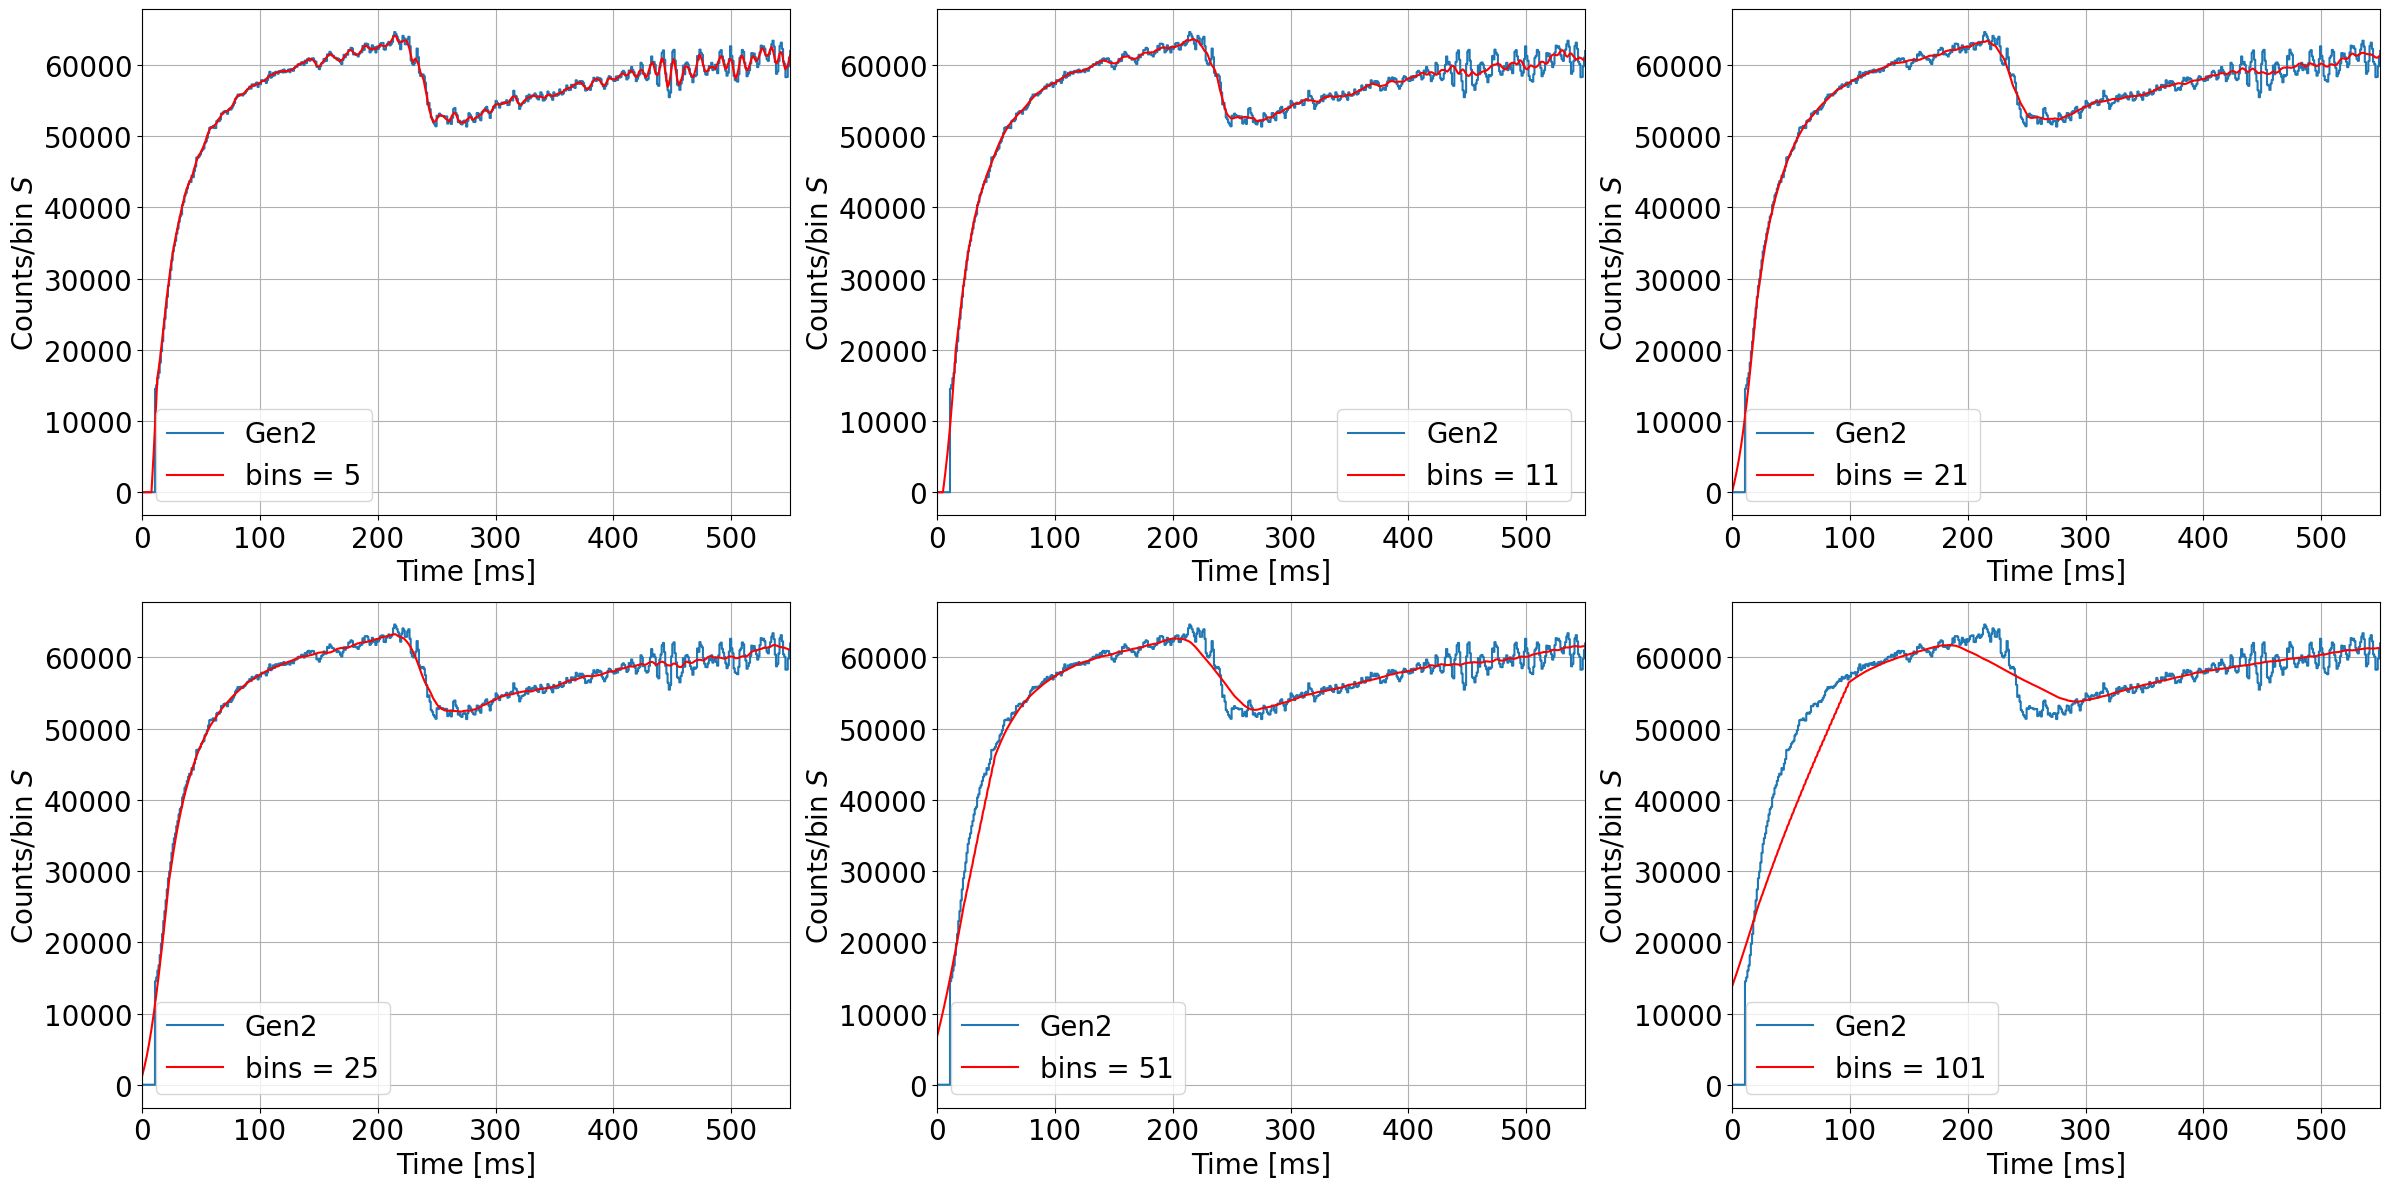

In [11]:
bw_range = np.array([5,11,21,25,51,101])
fig, ax = plt.subplots(2,3, figsize=(24,12))
ax = ax.ravel()

for i, bw in enumerate(bw_range):
    sig_avg_gen2 = moving_average(sig_gen2, n=bw, const_padding=True)
    ax[i].step(t, sig_gen2, where='post', label = 'Gen2')
    ax[i].plot(t, sig_avg_gen2, color = 'red', label='bins = {:.0f}'.format(bw))
    ax[i].set_xlabel("Time [ms]", fontsize = 20)
    ax[i].set_ylabel(r"Counts/bin $S$", fontsize = 20)
    ax[i].set_xlim((0,550))
    ax[i].grid()
    ax[i].tick_params(labelsize = 20)
    ax[i].legend(fontsize = 20)
plt.tight_layout()
plt.show()


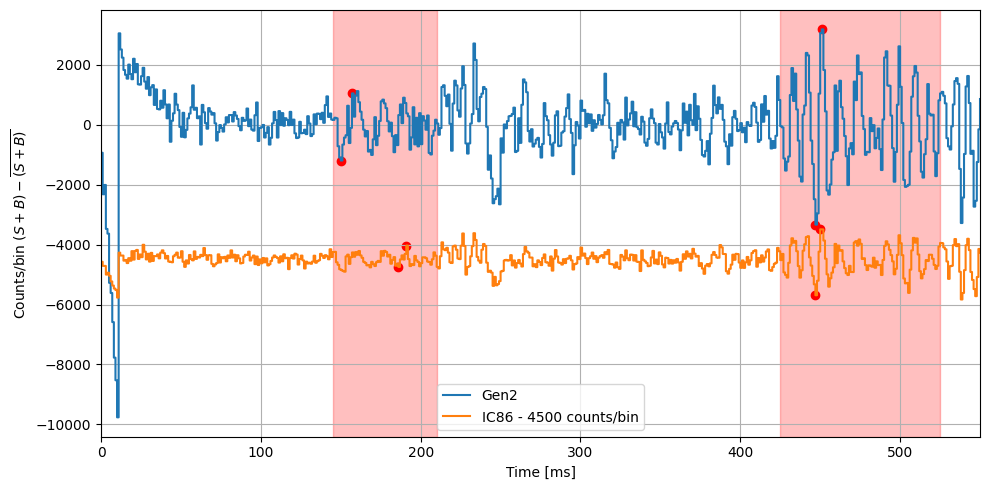

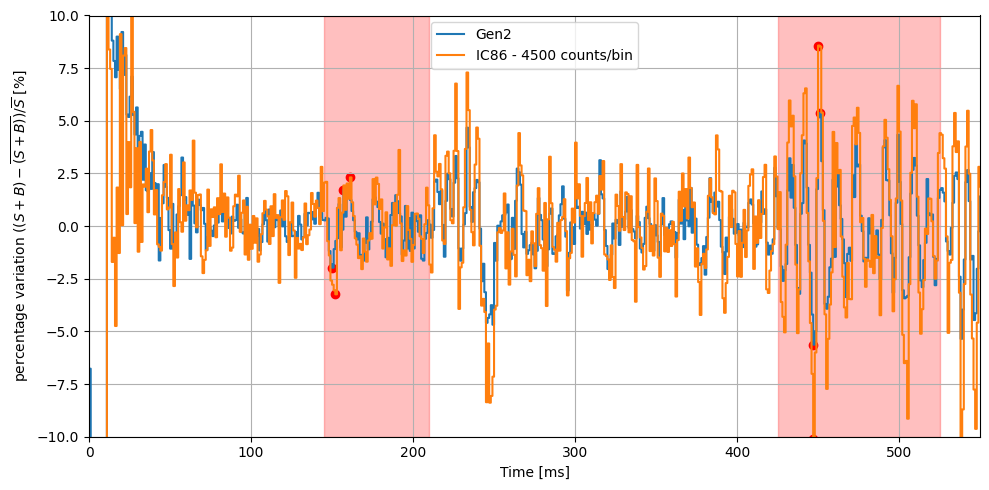

In [12]:
mw = 10
sasi1 = [145, 210] * u.ms
sasi2 = [425, 525] * u.ms

fig, ax = plt.subplots(1,1, figsize=(10,5))  
for i in range(2):
    if i == 0:
        dev = dev_gen2
        label = 'Gen2'
    elif i == 1:
        dev = dev_ic86-4500
        label = 'IC86 - 4500 counts/bin'
    # time bins for SASI period 1 and 2
    t_sasi1 = t[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    t_sasi2 = t[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    # amplitude
    a_sasi1 = dev[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    a_sasi2 = dev[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    # maximum amplitude variation within a window of mw bins
    da_sasi1, argmin_sasi1, argmax_sasi1 = min_max_in_window(a_sasi1, window=mw, return_index=True)
    da_sasi2, argmin_sasi2, argmax_sasi2 = min_max_in_window(a_sasi2, window=mw, return_index=True)

    ax.step(t, dev, where='post', label=label)
    ax.scatter(t_sasi1[argmin_sasi1], a_sasi1[argmin_sasi1], color = 'r', marker = 'o')
    ax.scatter(t_sasi1[argmax_sasi1], a_sasi1[argmax_sasi1], color = 'r', marker = 'o')
    ax.scatter(t_sasi2[argmin_sasi2], a_sasi2[argmin_sasi2], color = 'r', marker = 'o')
    ax.scatter(t_sasi2[argmax_sasi2], a_sasi2[argmax_sasi2], color = 'r', marker = 'o')
    

ax.axvspan(sasi1[0].value,sasi1[1].value,color = 'red', alpha = 0.25)
ax.axvspan(sasi2[0].value,sasi2[1].value,color = 'red', alpha = 0.25)
ax.set_xlabel("Time [ms]")
ax.set_ylabel(r"Counts/bin $(S+B)-\overline{(S+B)}$")
ax.set_xlim(0,550)
ax.legend()
ax.grid()
plt.tight_layout()


fig, ax = plt.subplots(1,1, figsize=(10,5))
for i in range(2):
    if i == 0:
        dev = dev_gen2/sig_avg_gen2
        label = 'Gen2'
    elif i == 1:
        dev = dev_ic86/sig_avg_ic86
        label = 'IC86 - 4500 counts/bin'
        
    dev *= 100
    
    # time bins for SASI period 1 and 2
    t_sasi1 = t[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    t_sasi2 = t[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    # amplitude
    a_sasi1 = dev[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    a_sasi2 = dev[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    # maximum amplitude variation within a window of mw bins
    da_sasi1, argmin_sasi1, argmax_sasi1 = min_max_in_window(a_sasi1, window=mw, return_index=True)
    da_sasi2, argmin_sasi2, argmax_sasi2 = min_max_in_window(a_sasi2, window=mw, return_index=True)

    ax.step(t, dev, where='post', label=label)
    ax.scatter(t_sasi1[argmin_sasi1], a_sasi1[argmin_sasi1], color = 'r', marker = 'o')
    ax.scatter(t_sasi1[argmax_sasi1], a_sasi1[argmax_sasi1], color = 'r', marker = 'o')
    ax.scatter(t_sasi2[argmin_sasi2], a_sasi2[argmin_sasi2], color = 'r', marker = 'o')
    ax.scatter(t_sasi2[argmax_sasi2], a_sasi2[argmax_sasi2], color = 'r', marker = 'o')
    

ax.axvspan(sasi1[0].value,sasi1[1].value,color = 'red', alpha = 0.25)
ax.axvspan(sasi2[0].value,sasi2[1].value,color = 'red', alpha = 0.25)
ax.set_xlabel("Time [ms]")
ax.set_ylabel(r"percentage variation $((S+B)-\overline{(S+B)})/\overline{S}$ [%]")
ax.set_xlim(0,550)
ax.set_ylim(-10,10)
ax.legend()
ax.grid()
plt.tight_layout()


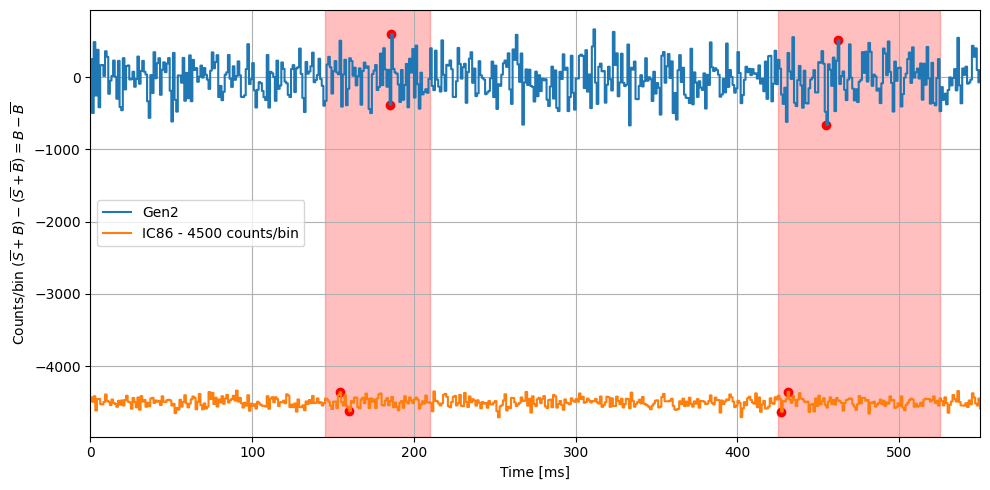

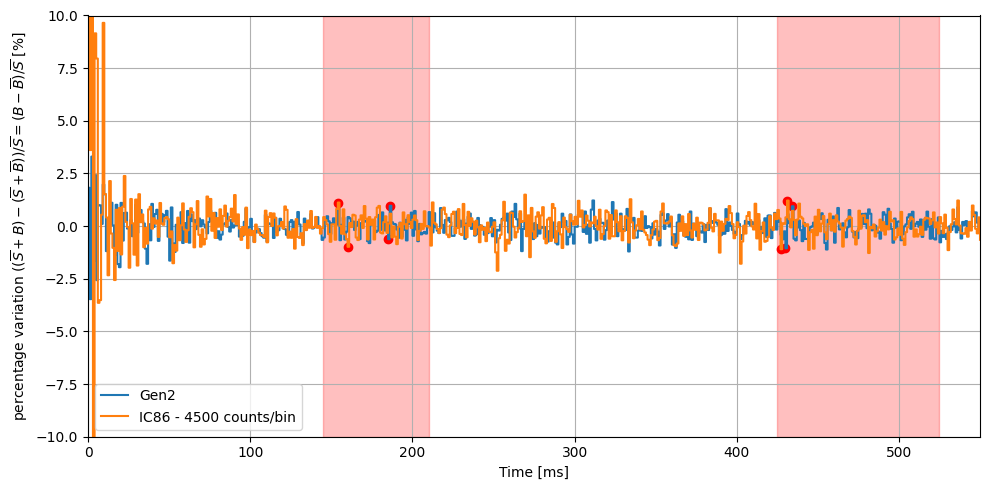

In [13]:
mw = 10
sasi1 = [145, 210] * u.ms
sasi2 = [425, 525] * u.ms

fig, ax = plt.subplots(1,1, figsize=(10,5))  

for i in range(2):
    if i == 0:
        dev = bkg_gen2-bkg_avg_gen2
        label = 'Gen2'
    elif i == 1:
        dev = bkg_ic86-bkg_avg_ic86-4500
        label = 'IC86 - 4500 counts/bin'
    # time bins for SASI period 1 and 2
    t_sasi1 = t[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    t_sasi2 = t[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    # amplitude
    a_sasi1 = dev[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    a_sasi2 = dev[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    # maximum amplitude variation within a window of mw bins
    da_sasi1, argmin_sasi1, argmax_sasi1 = min_max_in_window(a_sasi1, window=mw, return_index=True)
    da_sasi2, argmin_sasi2, argmax_sasi2 = min_max_in_window(a_sasi2, window=mw, return_index=True)

    ax.step(t, dev, where='post', label=label)
    ax.scatter(t_sasi1[argmin_sasi1], a_sasi1[argmin_sasi1], color = 'r', marker = 'o')
    ax.scatter(t_sasi1[argmax_sasi1], a_sasi1[argmax_sasi1], color = 'r', marker = 'o')
    ax.scatter(t_sasi2[argmin_sasi2], a_sasi2[argmin_sasi2], color = 'r', marker = 'o')
    ax.scatter(t_sasi2[argmax_sasi2], a_sasi2[argmax_sasi2], color = 'r', marker = 'o')

ax.axvspan(sasi1[0].value,sasi1[1].value,color = 'red', alpha = 0.25)
ax.axvspan(sasi2[0].value,sasi2[1].value,color = 'red', alpha = 0.25)
ax.set_xlabel("Time [ms]")
ax.set_ylabel(r"Counts/bin $(\overline{S}+B)-(\overline{S}+\overline{B})=B-\overline{B}$")
ax.set_xlim(0,550)
ax.legend()
ax.grid()
plt.tight_layout()

fig, ax = plt.subplots(1,1, figsize=(10,5))
for i in range(2):
    if i == 0:
        dev = (bkg_gen2-bkg_avg_gen2)/sig_avg_gen2
        label = 'Gen2'
    elif i == 1:
        dev = (bkg_ic86-bkg_avg_ic86)/sig_avg_ic86
        label = 'IC86 - 4500 counts/bin'
        
    dev *= 100
    
    # time bins for SASI period 1 and 2
    t_sasi1 = t[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    t_sasi2 = t[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    # amplitude
    a_sasi1 = dev[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    a_sasi2 = dev[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    # maximum amplitude variation within a window of mw bins
    da_sasi1, argmin_sasi1, argmax_sasi1 = min_max_in_window(a_sasi1, window=mw, return_index=True)
    da_sasi2, argmin_sasi2, argmax_sasi2 = min_max_in_window(a_sasi2, window=mw, return_index=True)

    ax.step(t, dev, where='post', label=label)
    ax.scatter(t_sasi1[argmin_sasi1], a_sasi1[argmin_sasi1], color = 'r', marker = 'o')
    ax.scatter(t_sasi1[argmax_sasi1], a_sasi1[argmax_sasi1], color = 'r', marker = 'o')
    ax.scatter(t_sasi2[argmin_sasi2], a_sasi2[argmin_sasi2], color = 'r', marker = 'o')
    ax.scatter(t_sasi2[argmax_sasi2], a_sasi2[argmax_sasi2], color = 'r', marker = 'o')
    

ax.axvspan(sasi1[0].value,sasi1[1].value,color = 'red', alpha = 0.25)
ax.axvspan(sasi2[0].value,sasi2[1].value,color = 'red', alpha = 0.25)
ax.set_xlabel("Time [ms]")
ax.set_ylabel(r"percentage variation $((\overline{S}+B)-(\overline{S}+\overline{B}))/\overline{S}=(B-\overline{B})/\overline{S}$ [%]")
ax.set_xlim(0,550)
ax.set_ylim(-10,10)
ax.legend()
ax.grid()
plt.tight_layout()

In [14]:
dt = 1*u.ms
bw = 11
mw = 10

samples = 1000
sim.scale_result(distance=2*u.kpc)

# time and signal for each detector component [counts/bin]
t, i3_sig = sim.detector_hits(dt=dt, subdetector='i3')
t, dc_sig = sim.detector_hits(dt=dt, subdetector='dc')
t, md_sig = sim.detector_hits(dt=dt, subdetector='md')
t, comb_sig = sim.detector_hits(dt=dt)

t = t.to(u.ms)

sasi1 = [145, 210] * u.ms
sasi2 = [425, 525] * u.ms
# time bins for SASI period 1 and 2
t_sasi1 = t[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
t_sasi2 = t[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

A_IC86 = [] # signal amplitude difference
A_Gen2 = []
B_IC86 = [] # background amplitude difference
B_Gen2 = []

#sim.detector.set_md_background(mu=sim.detector.i3_dom_bg_mu, sig=sim.detector.i3_dom_bg_sig)

# average background rate given by the mean of the sensor distribution and scaled to the full detector
bkg_avg_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
bkg_avg_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)


for i in np.arange(samples):
    # random background realization
    i3_bkg = sim.detector.i3_bg(dt=dt, size=len(i3_sig))
    dc_bkg = sim.detector.dc_bg(dt=dt, size=len(dc_sig))
    md_bkg = sim.detector.md_bg(dt=dt, size=len(md_sig))
    comb_bkg = i3_bkg + dc_bkg + md_bkg

    sig_ic86 = i3_sig + dc_sig
    sig_gen2 = comb_sig
    bkg_ic86 = i3_bkg + dc_bkg
    bkg_gen2 = comb_bkg

    # combined signal + background counts
    ic86 = sig_ic86 + bkg_ic86
    gen2 = sig_gen2 + bkg_gen2

    # moving average sig with bw binning size and constant padding
    sig_avg_ic86 = moving_average(sig_ic86, n=bw, const_padding=True)
    sig_avg_gen2 = moving_average(sig_gen2, n=bw, const_padding=True)

    # moving average sig + bkg
    avg_ic86 = sig_avg_ic86 + bkg_ic86
    avg_gen2 = sig_avg_gen2 + bkg_gen2
    
    for j in range(2):
        for k in range(2):
            #signal trials
            if j == 0:
                if k == 0:
                    #Gen2 case
                    dev = (gen2-sig_avg_gen2-bkg_avg_gen2)/sig_avg_gen2
                    #IC86 case
                elif k == 1:
                    dev = (ic86-sig_avg_ic86-bkg_avg_ic86)/sig_avg_ic86
            #background trials
            elif j == 1:
                if k == 0:
                    #Gen2 case
                    dev = (bkg_gen2-bkg_avg_gen2)/sig_avg_gen2
                    #IC86 case
                elif k == 1:
                    dev = (bkg_ic86-bkg_avg_ic86)/sig_avg_ic86

            a_sasi1 = dev[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
            a_sasi2 = dev[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

            da_sasi1 = min_max_in_window(a_sasi1, window=mw)
            da_sasi2 = min_max_in_window(a_sasi2, window=mw)
            
            #save data in respective list
            if j == 0:
                if k == 0:
                    A_Gen2.append([da_sasi1,da_sasi2])
                elif k == 1:
                    A_IC86.append([da_sasi1,da_sasi2])
            if j == 1:
                if k == 0:
                    B_Gen2.append([da_sasi1,da_sasi2])
                elif k == 1:
                    B_IC86.append([da_sasi1,da_sasi2])

/usr/local/lib/python3.8/dist-packages/astropy-5.2.2-py3.8-linux-x86_64.egg/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [15]:
A_Gen2 = np.array(A_Gen2)
A_IC86 = np.array(A_IC86)
B_Gen2 = np.array(B_Gen2)
B_IC86 = np.array(B_IC86)

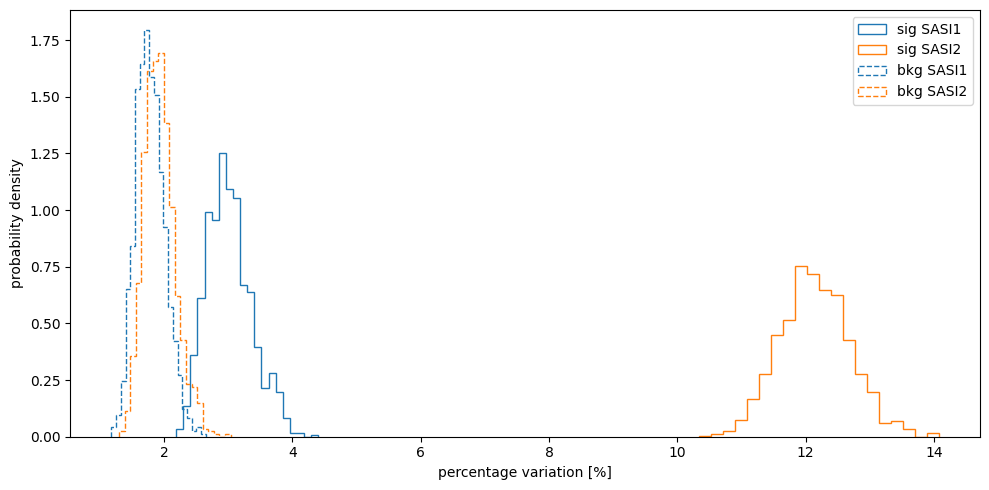

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,5))  

ax.hist(A_Gen2.T[0]*100, density=True, histtype = 'step', bins = 20, label='sig SASI1', color = 'C0', ls = '-')
ax.hist(A_Gen2.T[1]*100, density=True, histtype = 'step', bins = 20, label='sig SASI2', color = 'C1', ls = '-')
ax.hist(B_Gen2.T[0]*100, density=True, histtype = 'step', bins = 20, label='bkg SASI1', color = 'C0', ls = '--')
ax.hist(B_Gen2.T[1]*100, density=True, histtype = 'step', bins = 20, label='bkg SASI2', color = 'C1', ls = '--')
ax.legend()
ax.set_xlabel('percentage variation [%]')
ax.set_ylabel('probability density')
plt.tight_layout()

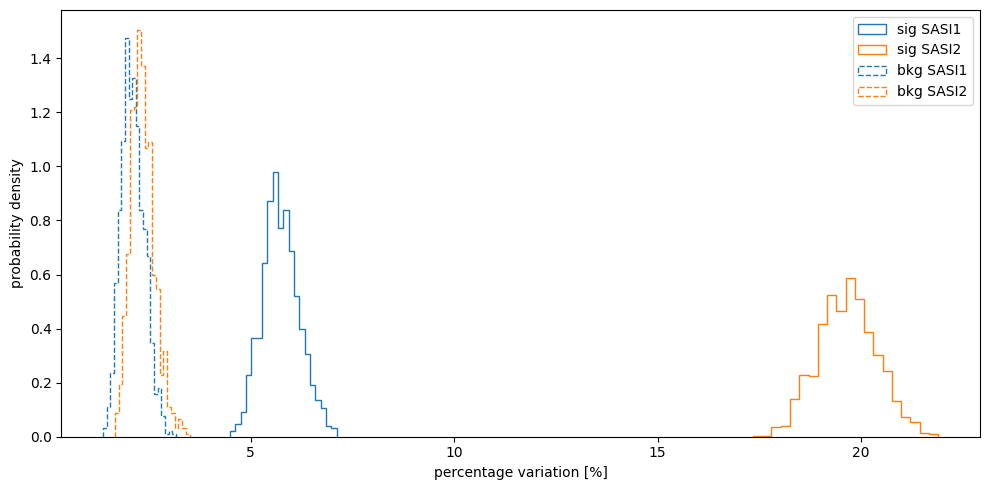

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,5))  

ax.hist(A_IC86.T[0]*100, density=True, histtype = 'step', bins = 20, label='sig SASI1', color = 'C0', ls = '-')
ax.hist(A_IC86.T[1]*100, density=True, histtype = 'step', bins = 20, label='sig SASI2', color = 'C1', ls = '-')
ax.hist(B_IC86.T[0]*100, density=True, histtype = 'step', bins = 20, label='bkg SASI1', color = 'C0', ls = '--')
ax.hist(B_IC86.T[1]*100, density=True, histtype = 'step', bins = 20, label='bkg SASI2', color = 'C1', ls = '--')
ax.legend()
ax.set_xlabel('percentage variation [%]')
ax.set_ylabel('probability density')
plt.tight_layout()

In [18]:
significance_SASI1_Gen2 = (A_Gen2.T[0].mean()-B_Gen2.T[0].mean())/(np.sqrt(A_Gen2.T[0].std()**2+B_Gen2.T[0].std()**2))
significance_SASI2_Gen2 = (A_Gen2.T[1].mean()-B_Gen2.T[1].mean())/(np.sqrt(A_Gen2.T[1].std()**2+B_Gen2.T[1].std()**2))
print('Gen2 at 2 kpc distance: significance of 1st SASI period: {:.1f}, significance of 2nd SASI period: {:.1f}'.format(significance_SASI1_Gen2, significance_SASI2_Gen2))

Gen2 at 2 kpc distance: significance of 1st SASI period: 3.0, significance of 2nd SASI period: 17.1


In [19]:
significance_SASI1_IC86 = (A_IC86.T[0].mean()-B_IC86.T[0].mean())/(np.sqrt(A_IC86.T[0].std()**2+B_IC86.T[0].std()**2))
significance_SASI2_IC86 = (A_IC86.T[1].mean()-B_IC86.T[1].mean())/(np.sqrt(A_IC86.T[1].std()**2+B_IC86.T[1].std()**2))
print('IC86 at 2 kpc distance: significance of 1st SASI period: {:.1f}, significance of 2nd SASI period: {:.1f}'.format(significance_SASI1_IC86, significance_SASI2_IC86))

IC86 at 2 kpc distance: significance of 1st SASI period: 6.8, significance of 2nd SASI period: 22.4


In [20]:
# runs full significance simulation for difference distances
dt = 1*u.ms
bw = 11
mw = 10

samples = 10000

sasi1 = [145, 210] * u.ms
sasi2 = [425, 525] * u.ms

sig_SASI1_IC86 = [] # signal amplitude difference
sig_SASI2_IC86 = []
sig_SASI1_Gen2 = [] # background amplitude difference
sig_SASI2_Gen2 = []

#sim.detector.set_md_background(mu=sim.detector.i3_dom_bg_mu, sig=sim.detector.i3_dom_bg_sig)

# average background rate given by the mean of the sensor distribution and scaled to the full detector
bkg_avg_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
bkg_avg_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)

#distance_range = np.array([0.5,1,2,5,10,20,50,100,200])
distance_range = np.logspace(np.log10(0.5),np.log10(100),20)

for d in distance_range:
    print('distance: {:.2f} kpc'.format(d))
    
    A_IC86 = [] # signal amplitude difference
    A_Gen2 = []
    B_IC86 = [] # background amplitude difference
    B_Gen2 = []
    sim.scale_result(distance=d*u.kpc)
    
    # time and signal for each detector component [counts/bin]
    t, i3_sig = sim.detector_hits(dt=dt, subdetector='i3')
    t, dc_sig = sim.detector_hits(dt=dt, subdetector='dc')
    t, md_sig = sim.detector_hits(dt=dt, subdetector='md')
    t, comb_sig = sim.detector_hits(dt=dt)
    
    t = t.to(u.ms)
    
    # time bins for SASI period 1 and 2
    t_sasi1 = t[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    t_sasi2 = t[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    for i in np.arange(samples):
        # random background realization
        i3_bkg = sim.detector.i3_bg(dt=dt, size=len(i3_sig))
        dc_bkg = sim.detector.dc_bg(dt=dt, size=len(dc_sig))
        md_bkg = sim.detector.md_bg(dt=dt, size=len(md_sig))
        comb_bkg = i3_bkg + dc_bkg + md_bkg

        sig_ic86 = i3_sig + dc_sig
        sig_gen2 = comb_sig
        bkg_ic86 = i3_bkg + dc_bkg
        bkg_gen2 = comb_bkg

        # combined signal + background counts
        ic86 = sig_ic86 + bkg_ic86
        gen2 = sig_gen2 + bkg_gen2

        # moving average sig with bw binning size and constant padding
        sig_avg_ic86 = moving_average(sig_ic86, n=bw, const_padding=True)
        sig_avg_gen2 = moving_average(sig_gen2, n=bw, const_padding=True)

        # moving average sig + bkg
        avg_ic86 = sig_avg_ic86 + bkg_ic86
        avg_gen2 = sig_avg_gen2 + bkg_gen2

        for j in range(2):
            for k in range(2):
                #signal trials
                if j == 0:
                    if k == 0:
                        #Gen2 case
                        dev = (gen2-sig_avg_gen2-bkg_avg_gen2)/sig_avg_gen2
                        #IC86 case
                    elif k == 1:
                        dev = (ic86-sig_avg_ic86-bkg_avg_ic86)/sig_avg_ic86
                #background trials
                elif j == 1:
                    if k == 0:
                        #Gen2 case
                        dev = (bkg_gen2-bkg_avg_gen2)/sig_avg_gen2
                        #IC86 case
                    elif k == 1:
                        dev = (bkg_ic86-bkg_avg_ic86)/sig_avg_ic86

                a_sasi1 = dev[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
                a_sasi2 = dev[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

                da_sasi1 = min_max_in_window(a_sasi1, window=mw)
                da_sasi2 = min_max_in_window(a_sasi2, window=mw)

                #save data in respective list
                if j == 0:
                    if k == 0:
                        A_Gen2.append([da_sasi1,da_sasi2])
                    elif k == 1:
                        A_IC86.append([da_sasi1,da_sasi2])
                if j == 1:
                    if k == 0:
                        B_Gen2.append([da_sasi1,da_sasi2])
                    elif k == 1:
                        B_IC86.append([da_sasi1,da_sasi2])
                        
    A_Gen2 = np.array(A_Gen2)
    A_IC86 = np.array(A_IC86)
    B_Gen2 = np.array(B_Gen2)
    B_IC86 = np.array(B_IC86)
    
    sig_SASI1_Gen2.append((A_Gen2.T[0].mean()-B_Gen2.T[0].mean())/(np.sqrt(A_Gen2.T[0].std()**2+B_Gen2.T[0].std()**2)))
    sig_SASI2_Gen2.append((A_Gen2.T[1].mean()-B_Gen2.T[1].mean())/(np.sqrt(A_Gen2.T[1].std()**2+B_Gen2.T[1].std()**2)))
    sig_SASI1_IC86.append((A_IC86.T[0].mean()-B_IC86.T[0].mean())/(np.sqrt(A_IC86.T[0].std()**2+B_IC86.T[0].std()**2)))
    sig_SASI2_IC86.append((A_IC86.T[1].mean()-B_IC86.T[1].mean())/(np.sqrt(A_IC86.T[1].std()**2+B_IC86.T[1].std()**2)))


distance: 0.50 kpc
distance: 0.66 kpc
distance: 0.87 kpc
distance: 1.15 kpc
distance: 1.53 kpc
distance: 2.02 kpc
distance: 2.66 kpc
distance: 3.52 kpc
distance: 4.65 kpc
distance: 6.15 kpc
distance: 8.13 kpc
distance: 10.74 kpc
distance: 14.20 kpc
distance: 18.77 kpc
distance: 24.80 kpc
distance: 32.78 kpc
distance: 43.32 kpc
distance: 57.25 kpc
distance: 75.66 kpc
distance: 100.00 kpc


In [21]:
data = np.array([sig_SASI1_Gen2, sig_SASI2_Gen2, sig_SASI1_IC86, sig_SASI2_IC86])
np.savetxt("significance_Gen2+IC86_WLS_1E4_trials.txt", data.T, delimiter = " ", newline = "\n")

In [22]:
data = np.genfromtxt("significance_Gen2+IC86_WLS_1E4_trials.txt", delimiter=" ", dtype=float)
sig_SASI1_Gen2, sig_SASI2_Gen2, sig_SASI1_IC86, sig_SASI2_IC86 = data.T

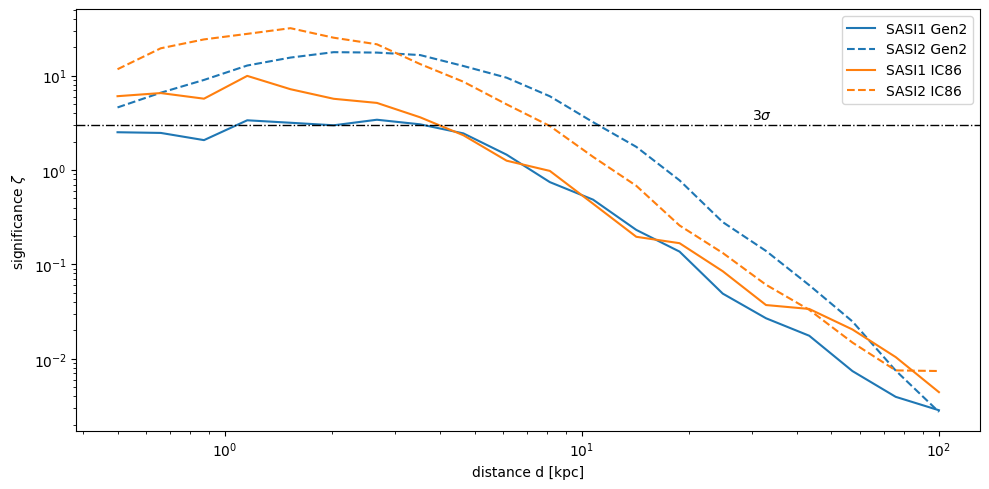

In [23]:
distance = distance_range
fig, ax = plt.subplots(1,1, figsize=(10,5))  
ax.plot(distance, sig_SASI1_Gen2, color = 'C0', ls = '-', label='SASI1 Gen2')
ax.plot(distance, sig_SASI2_Gen2, color = 'C0', ls = '--', label='SASI2 Gen2')
ax.plot(distance, sig_SASI1_IC86, color = 'C1', ls = '-', label='SASI1 IC86')
ax.plot(distance, sig_SASI2_IC86, color = 'C1', ls = '--', label='SASI2 IC86')
ax.axhline(3, color = 'black', ls = '-.', lw = 1)
ax.text(30, 3.5, s=r'3$\sigma$')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('distance d [kpc]')
ax.set_ylabel(r'significance $\zeta$')
plt.tight_layout()

(array([  7.,  21.,  79., 155., 242., 229., 154.,  77.,  25.,  11.]),
 array([ 99.61677308, 115.26488898, 130.91300487, 146.56112077,
        162.20923666, 177.85735256, 193.50546845, 209.15358435,
        224.80170024, 240.44981613, 256.09793203]),
 [<matplotlib.patches.Polygon at 0x7f09e43a1eb0>])

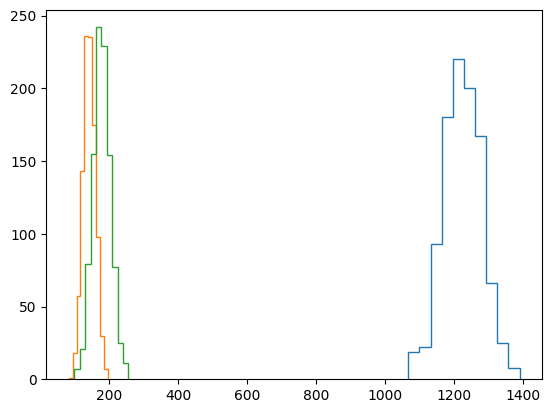

In [24]:
plt.hist(sim.detector.md_dom_bg(size=1000), histtype='step')
plt.hist(sim.detector.i3_dom_bg(size=1000), histtype='step')
plt.hist(sim.detector.dc_dom_bg(size=1000), histtype='step')

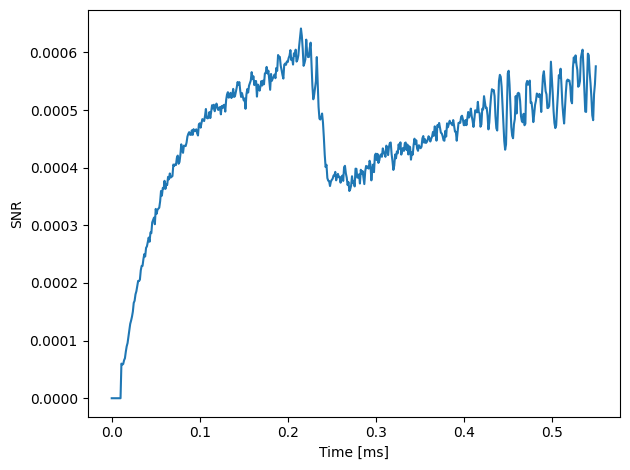

In [28]:
bkg = sim.detector.md_bg()+sim.detector.i3_bg()+sim.detector.dc_bg()
t, sig = sim.detector_hits(dt)
snr = sig/bkg

fig, ax = plt.subplots(1,1)
ax.plot(t, snr)
ax.set_xlabel('Time [ms]')
ax.set_ylabel('SNR')
plt.tight_layout()